In [1]:
%matplotlib inline

In [2]:
from edc import check_compatibility
check_compatibility("user-0.24.5", dependencies=["SH"])



---------

The following environment variables are available:

* `SH_CLIENT_SECRET`, `SH_CLIENT_NAME`, `SH_INSTANCE_ID`, `SH_CLIENT_ID`


In [3]:
from xcube_sh.config import CubeConfig
from xcube_sh.cube import open_cube
from xcube_sh.sentinelhub import SentinelHub
import xarray as xr

from sentinelhub import BBox, WmsRequest, DataSource, SHConfig
from functools import partial

In [4]:
# Set Sentinel Hub credentials

import os
sh_credentials = dict(client_id=os.environ['SH_CLIENT_ID'],
                      client_secret=os.environ['SH_CLIENT_SECRET']) # This is only provided when the Oauth credentials are created

# Sentinel-3 OLCI, Sentinel-3 SLSTR and Sentinel-5 layers are processed on different infrastructure, 
# which requires to used different end-point

sh_credentials.update(api_url='https://creodias.sentinel-hub.com')

Set the area for three ship lanes far from land:

In [6]:
#     'Center of Gulf of Mexico':         ranges(( -92.0,  -89.0), (26, 28)),
#     'West of San Diego':         ranges(( -125.0,  -118.0), (27, 32)),
#     'West of Los Angeles':         ranges(( -129.0,  -123.0), (31, 38)),

#Define two regions
region1 = dict()
region1['name'] = 'gulf_of_mexico'#'Center of Gulf of Mexico'
region1['x1'] = -92
region1['y1'] = 26
region1['x2'] = -89
region1['y2'] = 28

region2 = dict()
region2['name'] = 'san_diego'#'West of San Diego'
region2['x1'] = -125
region2['y1'] = 27
region2['x2'] = -118
region2['y2'] = 32

region3 = dict()
region3['name'] = 'los_angeles'#'West of Los Angeles'
region3['x1'] = -129
region3['y1'] = 31
region3['x2'] = -123
region3['y2'] = 38


region4 = dict()
region4['name'] = 'huston'#'Center of Gulf of Mexico'
region4['x1'] = -95.5
region4['y1'] = 29.6
region4['x2'] = -95.1
region4['y2'] = 29.9

region5 = dict()
region5['name'] = 'los_angeles_city'#'West of San Diego'
region5['x1'] = -118.4
region5['y1'] = 33.95
region5['x2'] = -118.1
region5['y2'] = 34.15

region6 = dict()
region6['name'] = 'victoria'#'West of Los Angeles'
region6['x1'] = -123.7
region6['y1'] = 48.3
region6['x2'] = -123.3
region6['y2'] = 48.6

geometry = [region1, region2, region3, region4, region5, region6]

In [11]:
timerange = ['2019-12-01', '2020-06-30']

def get_data(geometry):
    cubes = []
    for idx,geo in enumerate(geometry):
        cube_config = CubeConfig(dataset_name='S5PL2',
                             band_names=['NO2', 'SO2', 'CLOUD_FRACTION'],
                             # tile_size=[512, 512],
                             bbox=(geo['x1'], geo['y1'], geo['x2'], geo['y2']),
                             spatial_res=0.02, #abs(bbox[2]-bbox[0])/512,
                             time_range= timerange,
                             time_period='1D'
                                ) 

        cube = open_cube(cube_config, **sh_credentials)
        cubes.append(cube)
    return cubes

cubes = get_data(geometry)

Check the TROPOMI passing time:

In [8]:
# cubes[0].time
for idx,cube in enumerate(cubes):
    print(geometry[idx]['name'], cube.time)

gulf_of_mexico <xarray.DataArray 'time' (time: 213)>
array(['2019-12-01T12:00:00.000000000', '2019-12-02T12:00:00.000000000',
       '2019-12-03T12:00:00.000000000', ..., '2020-06-28T12:00:00.000000000',
       '2020-06-29T12:00:00.000000000', '2020-06-30T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2019-12-01T12:00:00 ... 2020-06-30T12:00:00
Attributes:
    standard_name:  time
    bounds:         time_bnds
san_diego <xarray.DataArray 'time' (time: 213)>
array(['2019-12-01T12:00:00.000000000', '2019-12-02T12:00:00.000000000',
       '2019-12-03T12:00:00.000000000', ..., '2020-06-28T12:00:00.000000000',
       '2020-06-29T12:00:00.000000000', '2020-06-30T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2019-12-01T12:00:00 ... 2020-06-30T12:00:00
Attributes:
    standard_name:  time
    bounds:         time_bnds
los_angeles <xarray.DataArray 'time' (time: 213)>
array(['2019-12-01T12

If we comment out the `time_period='1D'`, we can see they're around 18 -- 21 UTC.
So, we can choose 20:00 UTC for wind data and 15:00 -- 21:00 UTC for summation of ship density.

Let's calcualte the mean NO2 and CF. This method costs 30 minutes to generate one mean file ... It's better to use FIS.

In [12]:
savedir = '../data/tropomi_mean/'
for idx,cube in enumerate(cubes):
    if idx >=4:
        print(geometry[idx]['name'])
        savename = 'tropomi_'+geometry[idx]['name']+'_'+cube.time.min().dt.strftime('%Y%m').values+'-'+cube.time.max().dt.strftime('%Y%m').values+'.nc'
        load_data = cube.mean(['lon', 'lat']).load()
        load_data.to_netcdf(savedir+savename)

los_angeles_city


/opt/conda/envs/eurodatacube-0.24.5/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


victoria


/opt/conda/envs/eurodatacube-0.24.5/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Check the mean NO2 data:

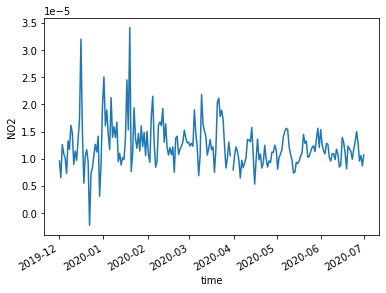

In [31]:
import xarray as xr
ds = xr.open_dataset(savedir+savename)
ds.isel(time=slice(0, 400))['NO2'].plot()